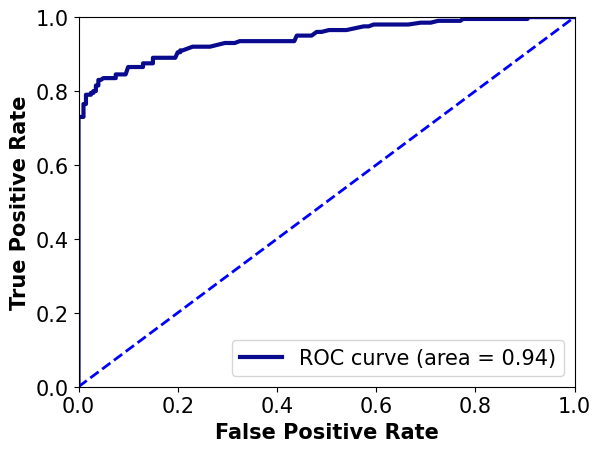

In [11]:
import pandas as pd
import numpy as np
import os
import math
from sklearn.metrics import roc_curve, auc
import hashlib
import matplotlib.pyplot as plt


dataset = "synthetic"

original_file = '../dataset/synthetic_data.csv'
origin = pd.read_csv(original_file)

seed = 10000

medv_max = origin['dimension_0'].max()
medv_min = origin['dimension_0'].min()


gamma = 1/2
k = 10
g = 3
secret_key = "123"

columns_of_interest = ['dimension_1', 'dimension_2'] 
origin[columns_of_interest] = origin[columns_of_interest].fillna(0)  

np.random.seed(seed)
intervals = np.linspace(medv_min, medv_max, k + 1)
segments = [(intervals[i], intervals[i + 1]) for i in range(k)]
np.random.shuffle(segments)
half_k = k // 2
green_domains = segments[:half_k]
red_domains = segments[half_k:]
green_domain_values = [(low, np.nextafter(high, low)) for low, high in green_domains]

def hash_mod(key, mod_value):
    combined = f"{secret_key}{key}"
    hash_value = int(hashlib.sha256(combined.encode()).hexdigest(), 16) 
    return hash_value % mod_value 

def first_two_digits(x):
    if x == 0:
        return "00"
    digits = str(x).lstrip('0.').replace('.', '') 
    if len(digits) == 1:  
        return digits + "0"  
    return digits[:2]  

def calculate_z_score(watermarked_data):
    green_cell = 0
    n_cell = 0

    for idx in range(len(watermarked_data)):
        selected_data = watermarked_data.loc[idx, columns_of_interest]
        first_two_digits_data = selected_data.apply(first_two_digits)
        composite_numbers = ''.join(first_two_digits_data.values)
        if(hash_mod(composite_numbers, g) != 0):
            continue
        n_cell += 1
    
        for low, high in green_domains:
            if low <= watermarked_data.loc[idx, 'dimension_0'] < high:
                green_cell += 1
                break
    
    z_score = (green_cell - n_cell/2) / math.sqrt(n_cell/4)
    return z_score



# 计算所有水印数据集的 z-score
z_scores = []
true_labels = []

path = 'ROC_datasets/attack_synthetic/'
for file in os.listdir(path):
    if file.endswith('.csv'):
        # print(file)
        watermarked_data = pd.read_csv(os.path.join(path, file))

        z_score = calculate_z_score(watermarked_data)
        # print(z_score)
        z_scores.append(z_score)
        true_labels.append(0)  


path = 'ROC_datasets/attack_watermarked'
for file in os.listdir(path):
    if file.endswith('.csv'):
        # print(file)
        watermarked_data = pd.read_csv(os.path.join(path, file))

        z_score = calculate_z_score(watermarked_data)
        z_scores.append(z_score)
        true_labels.append(1)  

path = 'ROC_datasets/generated'
for file in os.listdir(path):
    if file.endswith('.csv'):
        watermarked_data = pd.read_csv(os.path.join(path, file))

        z_score = calculate_z_score(watermarked_data)
        z_scores.append(z_score)
        true_labels.append(0)  
        
fpr, tpr, _ = roc_curve(true_labels, z_scores)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.rcParams['font.size'] = 15
plt.plot(fpr, tpr, color='#0a0a8f', lw=3, label=f'ROC curve (area = {roc_auc:.2f})')  # 红色，线宽为3
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')  # 蓝色，线宽为2
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
# plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig("ROC_syth.pdf", bbox_inches='tight')
plt.show()
